In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import fftpack
from scipy.optimize import minimize
from scipy.signal import butter, lfilter
from scipy.ndimage import generic_filter

from sklearn.preprocessing import StandardScaler

import cvxpy as cvx

def L1_norm(x):
    return np.linalg.norm(x, ord=1)

def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1070, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

def bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def lowpass(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='lowpass', analog=False)
    y = lfilter(b, a, data)
    return y

def highpass(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='highpass', analog=False)
    y = lfilter(b, a, data)
    return y

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Compressive sensing on a simple signal

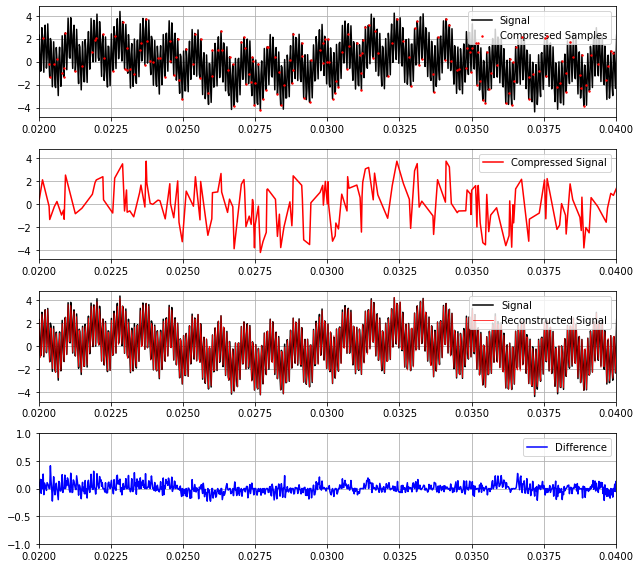

In [2]:
"""
Generate a simple signal that is the sum of multiple sine waves,
randomly downsample the signal and use convex optimization of 
the L1 norm to recontruct the signal
"""


## Number of samples
n = 4096

## Sample frequency
fs = 44000

## Signal time
t = np.arange(n)/fs


## Generate a signal
sig_freqs = [100, 1150, 10000, 20000]
sig_amps = [1, 1.2, 2, 0.5]

x = np.zeros(n)
for f, a in zip(sig_freqs, sig_amps):
    _x = np.sin(2*np.pi*f*t) * a
    x = x + _x
    
    
## Downsampling
downsamp_percent = 0.2
m = int(downsamp_percent * n)
m_idx = np.random.choice(n, m, replace=False)
m_idx.sort()

## Downsample the signal
x_down = x[m_idx]
t_down = t[m_idx]


## Basis function
basis_func = "dct"  #choose "fft" or "dct"

if basis_func=="fft":   ## currently failing to converg
    Psi = fftpack.ifft(np.identity(n), axis=0)
elif basis_func=="dct":
    Psi = fftpack.idct(np.identity(n), norm="ortho", axis=0)
Psi_down = Psi[m_idx]

## Use convex optimization for L1 norm
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [Psi_down@vx == x_down]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cvx.ECOS)


## Reconstruct signal
x_recon = np.squeeze(np.array(vx.value))

if basis_func=="fft":
    x_CS = fftpack.ifft(x_recon, axis=0)
elif basis_func=="dct":
    x_CS = fftpack.idct(x_recon, norm="ortho", axis=0)


## Plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9,8))
xlims = (0.02, 0.04)

ax[0].plot(t, x, color="black", label="Signal")
ax[0].scatter(t_down, x_down, color="red", zorder=10, s=2, label="Compressed Samples")

ax[1].plot(t_down, x_down, color="red", label="Compressed Signal")

ax[2].plot(t, x, color="black", lw=1.5, label="Signal")
ax[2].plot(t, x_CS, color="red", lw=0.75, label="Reconstructed Signal")

ax[3].plot(t, x-x_CS, color="blue", label="Difference")
ax[3].set_ylim(-1, 1)

for axis in ax.flatten():
    axis.grid("both")
    axis.set_xlim(xlims[0], xlims[1])
    axis.legend(loc="upper right")

plt.tight_layout()
plt.show()

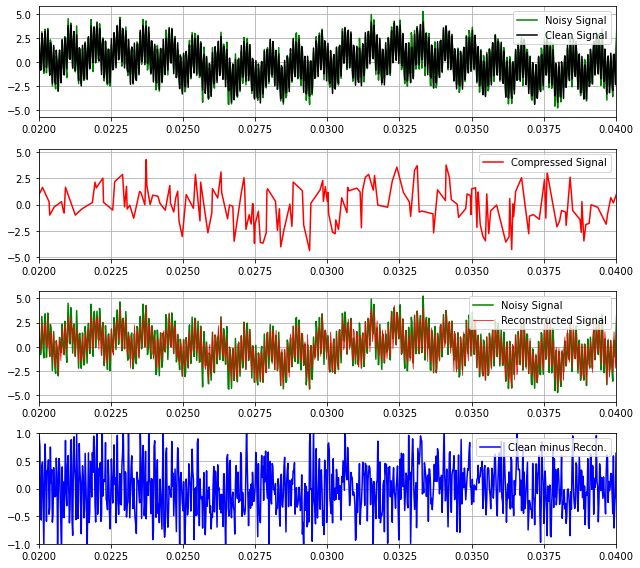

In [3]:
"""
Same as above, but add bandlimited noise to the signal
"""

## Add bandlimited noise to the signal
bl_minfreq = sig_freqs[1]
bl_maxfreq = sig_freqs[-2]
noise_scaler = 50
bl_noise = band_limited_noise(bl_minfreq, bl_maxfreq, samples=n, samplerate=fs) * noise_scaler
x_noisy = x + bl_noise


## Use same downsampling indices
x_noisy_down = x_noisy[m_idx]

## Use convex optimization for L1 norm
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [Psi_down@vx == x_noisy_down]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cvx.ECOS)


## Reconstruct signal
x_noisy_recon = np.squeeze(np.array(vx.value))

if basis_func=="fft":
    x_noisy_CS = fftpack.ifft(x_noisy_recon, axis=0)
elif basis_func=="dct":
    x_noisy_CS = fftpack.idct(x_noisy_recon, norm="ortho", axis=0)


## Plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9,8))
xlims = (0.02, 0.04)

ax[0].plot(t, x_noisy, color="green", label="Noisy Signal")
ax[0].plot(t, x, color="black", label="Clean Signal")

ax[1].plot(t_down, x_noisy_down, color="red", label="Compressed Signal")

ax[2].plot(t, x_noisy, color="green", lw=1.5, label="Noisy Signal")
ax[2].plot(t, x_noisy_CS, color="red", lw=0.75, label="Reconstructed Signal")

ax[3].plot(t, x-x_noisy_CS, color="blue", label="Clean minus Recon.")
ax[3].set_ylim(-1, 1)

for axis in ax.flatten():
    axis.grid("both")
    axis.set_xlim(xlims[0], xlims[1])
    axis.legend(loc="upper right")

plt.tight_layout()
plt.show()

C:\Users\amos\miniconda3\envs\geophysics_space\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


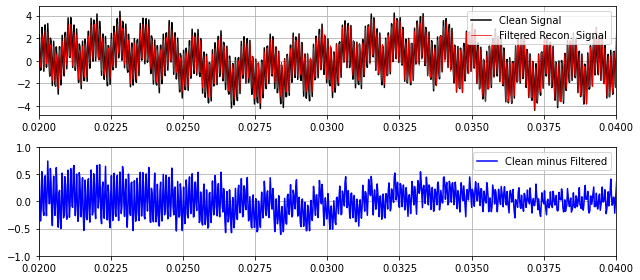

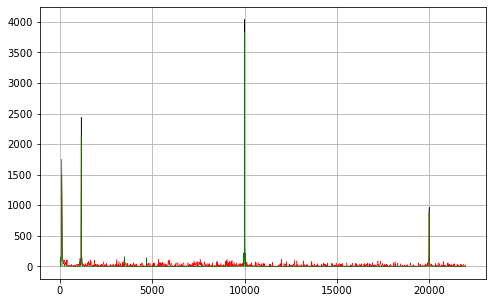

In [4]:
"""
Now use frequency thresholding to mitigate noise in the reconstructed signal
"""

x_fft = fftpack.fft(x)
x_noisy_CS_fft = fftpack.fft(x_noisy_CS)
freqs = np.fft.fftfreq(n, d=1/fs)

threshold = 125
x_filt_fft = np.copy(x_noisy_CS_fft)
x_filt_fft[np.abs(x_filt_fft)<threshold] = 0
x_filt = fftpack.ifft(x_filt_fft)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(9,4))
ax[0].plot(t, x, color="black", label="Clean Signal")
ax[0].plot(t, x_filt, color="red", lw=0.75, label="Filtered Recon. Signal")

ax[1].plot(t, x-x_filt, color="blue", label="Clean minus Filtered")
ax[1].set_ylim(-1, 1)

for axis in ax.flatten():
    axis.grid("both")
    axis.set_xlim(xlims[0], xlims[1])
    axis.legend(loc="upper right")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(freqs[:n//2], np.abs(x_fft[:n//2]), color="black", lw=0.5)
plt.plot(freqs[:n//2], np.abs(x_noisy_CS_fft[:n//2]), color="red", lw=0.5)
plt.plot(freqs[:n//2], np.abs(x_filt_fft[:n//2]), color="green", lw=0.5)
plt.grid("both")
plt.show()

### Neighbor-Aware Compressive Sensing

C:\Users\amos\miniconda3\envs\geophysics_space\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


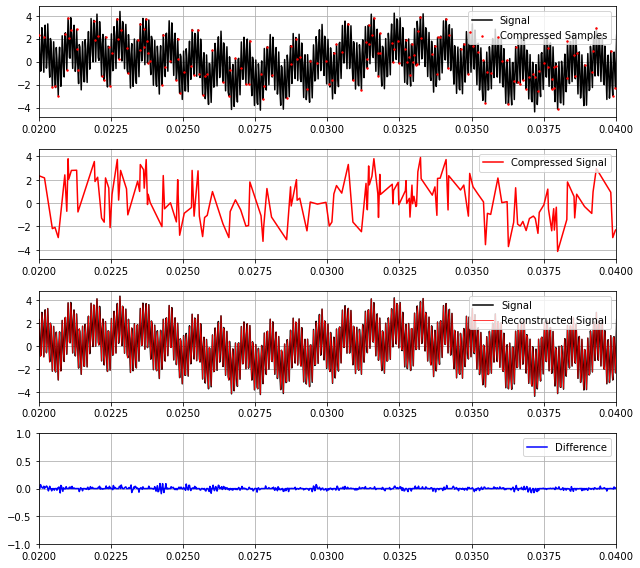

In [5]:
"""
For a given signal, assume there are two neighboring signals 
that are very similar. Each signal is downsampled with different 
random samples. Since we assume the signals are similar, set the 
optimization to provide a single signal that minimizes all three 
compressed signals
"""

## Number of samples
n = 4096

## Sample frequency
fs = 44000

## Signal time
t = np.arange(n)/fs


## Generate a signal
sig_freqs = [100, 1150, 10000, 20000]
sig_amps = [1, 1.2, 2, 0.5]

x = np.zeros(n)
for f, a in zip(sig_freqs, sig_amps):
    _x = np.sin(2*np.pi*f*t) * a
    x = x + _x
    
    
## Downsampling
downsamp_percent = 0.2
m = int(downsamp_percent * n)

## Downsample the signal
C1 = np.random.choice(n, m, replace=False)
C1.sort()
x_down1 = x[C1]
t_down1 = t[C1]
C2 = np.random.choice(n, m, replace=False)
C2.sort()
x_down2 = x[C2]
t_down2 = t[C2]
C3 = np.random.choice(n, m, replace=False)
C3.sort()
x_down3 = x[C3]
t_down3 = t[C3]


## Basis function
basis_func = "dct"  #choose "fft" or "dct"

if basis_func=="fft":   ## currently failing to converg
    Psi = fftpack.ifft(np.identity(n), axis=0)
elif basis_func=="dct":
    Psi = fftpack.idct(np.identity(n), norm="ortho", axis=0)
    
Psi_down1 = Psi[C1]
Psi_down2 = Psi[C2]
Psi_down3 = Psi[C3]


### TRYING MULTI CONSTRAINTS
## Use convex optimization for L1 norm

## UNSURE HOW TO MINIMIZE ON MULTIPLE OBJECTIVE, CURRENTLY PASSING
## AS MULTIPLE CONSTRAINTS

vx1 = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx1, 1))
constraints = [Psi_down1@vx1 == x_down1, Psi_down2@vx1 == x_down2, Psi_down3@vx1 == x_down3]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cvx.ECOS)


## Reconstruct signal
x_recon = np.squeeze(np.array(vx1.value))

if basis_func=="fft":
    x_CS = fftpack.ifft(x_recon, axis=0)
elif basis_func=="dct":
    x_CS = fftpack.idct(x_recon, norm="ortho", axis=0)


## Plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9,8))
xlims = (0.02, 0.04)

ax[0].plot(t, x, color="black", label="Signal")
ax[0].scatter(t_down2, x_down2, color="red", zorder=10, s=2, label="Compressed Samples")

ax[1].plot(t_down2, x_down2, color="red", label="Compressed Signal")

ax[2].plot(t, x, color="black", lw=1.5, label="Signal")
ax[2].plot(t, x_CS, color="red", lw=0.75, label="Reconstructed Signal")

ax[3].plot(t, x-x_CS, color="blue", label="Difference")
ax[3].set_ylim(-1, 1)

for axis in ax.flatten():
    axis.grid("both")
    axis.set_xlim(xlims[0], xlims[1])
    axis.legend(loc="upper right")

plt.tight_layout()
plt.show()

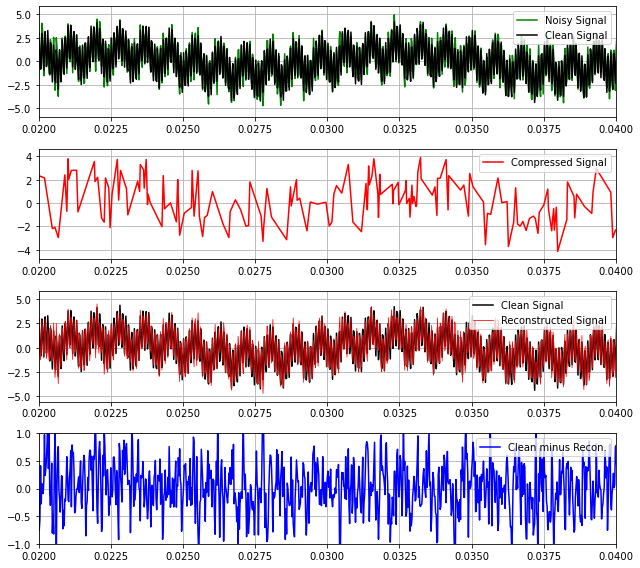

In [6]:
"""
Same as above, but add bandlimited noise to the signals
"""

## Add bandlimited noise to the signal
bl_minfreq = sig_freqs[1]
bl_maxfreq = sig_freqs[-2]
noise_scaler = 50
bl_noise = band_limited_noise(bl_minfreq, bl_maxfreq, samples=n, samplerate=fs) * noise_scaler
x_noisy = x + bl_noise


## Use same downsampling indices
x_noisy_down1 = x_noisy[C1]
x_noisy_down2 = x_noisy[C2]
x_noisy_down3 = x_noisy[C3]


### TRYING MULTI CONSTRAINTS
## Use convex optimization for L1 norm
vx1 = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx1, 1))
constraints = [Psi_down1@vx1 == x_noisy_down1, Psi_down2@vx1 == x_noisy_down2, Psi_down3@vx1 == x_noisy_down3]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False, solver=cvx.ECOS)


## Reconstruct signal
x_recon = np.squeeze(np.array(vx1.value))

if basis_func=="fft":
    x_noisy_CS = fftpack.ifft(x_recon, axis=0)
elif basis_func=="dct":
    x_noisy_CS = fftpack.idct(x_recon, norm="ortho", axis=0)


## Plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9,8))
xlims = (0.02, 0.04)

ax[0].plot(t, x_noisy, color="green", label="Noisy Signal")
ax[0].plot(t, x, color="black", label="Clean Signal")

ax[1].plot(t_down2, x_down2, color="red", label="Compressed Signal")

ax[2].plot(t, x, color="black", lw=1.5, label="Clean Signal")
ax[2].plot(t, x_noisy_CS, color="red", lw=0.75, label="Reconstructed Signal")

ax[3].plot(t, x-x_noisy_CS, color="blue", label="Clean minus Recon.")
ax[3].set_ylim(-1, 1)

for axis in ax.flatten():
    axis.grid("both")
    axis.set_xlim(xlims[0], xlims[1])
    axis.legend(loc="upper right")

plt.tight_layout()
plt.show()

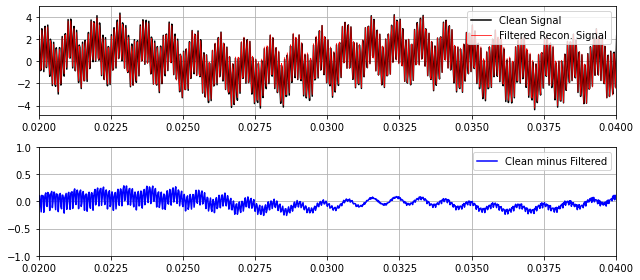

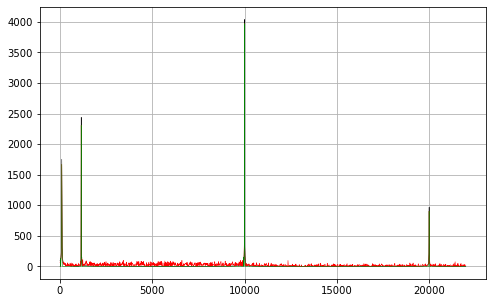

In [7]:
"""
Now use frequency thresholding to mitigate noise in the reconstructed signal
"""

x_fft = fftpack.fft(x)
x_noisy_CS_fft = fftpack.fft(x_noisy_CS)
freqs = np.fft.fftfreq(n, d=1/fs)

threshold = 125
x_filt_fft = np.copy(x_noisy_CS_fft)
x_filt_fft[np.abs(x_filt_fft)<threshold] = 0
x_filt = fftpack.ifft(x_filt_fft)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(9,4))
ax[0].plot(t, x, color="black", label="Clean Signal")
ax[0].plot(t, x_filt, color="red", lw=0.75, label="Filtered Recon. Signal")

ax[1].plot(t, x-x_filt, color="blue", label="Clean minus Filtered")
ax[1].set_ylim(-1, 1)

for axis in ax.flatten():
    axis.grid("both")
    axis.set_xlim(xlims[0], xlims[1])
    axis.legend(loc="upper right")

plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.plot(freqs[:n//2], np.abs(x_fft[:n//2]), color="black", lw=0.5)
plt.plot(freqs[:n//2], np.abs(x_noisy_CS_fft[:n//2]), color="red", lw=0.5)
plt.plot(freqs[:n//2], np.abs(x_filt_fft[:n//2]), color="green", lw=0.5)
plt.grid("both")
plt.show()